In [1]:
import os
import sys
import itertools

import numpy as np
import pandas as pd

from glob import glob
from tqdm import tqdm
from PIL import Image

import tensorflow as tf
import keras
from keras import optimizers
from keras.applications import VGG19
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ROOT_DIR = "chest_xray"

CREATE_DIR = False
IN_GOOGLE_COLAB = True

if IN_GOOGLE_COLAB:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')

    # change the current working directory
    %cd gdrive/'My Drive'

if CREATE_DIR:
    %mkdir $ROOT_DIR

%cd $ROOT_DIR

Mounted at /content/gdrive
/content/gdrive/My Drive
/content/gdrive/My Drive/chest_xray


In [3]:
DATASET_URL = "https://data.mendeley.com/public-files/datasets/rscbjbr9sj/files/f12eaf6d-6023-432f-acc9-80c9d7393433/file_downloaded"

DOWNLOAD_DATASET = False
EXTRACT_DATASET = False

if DOWNLOAD_DATASET:
    !wget $DATASET_URL

if EXTRACT_DATASET:
    !unzip file_downloaded

In [4]:
# input image shape
IMAGE_SIZE = (64, 64)

DATASET_PATH = os.path.abspath('chest_xray/')

# dict for encoding the dataset labels
classID = {'normal': 0, 'pneumonia': 1}

dataset = []

# iterate over test and train sets
for fold_dir in glob(os.path.join(DATASET_PATH, '*')):
    fold = fold_dir.split('/')[-1].lower()
    print('\n> ' + fold)

    # iterate over classes in a set
    for class_dir in glob(os.path.join(fold_dir, '*')):
        label = class_dir.split('/')[-1].lower()
        print(label)

        # iteratea over image files in a class
        for filename in tqdm(os.listdir(class_dir), file=sys.stdout):
            if filename.endswith(".jpeg"):
                # get additional info about the type of pneumonia
                if label == 'pneumonia':
                    info = filename.split("_")[1]     # possible types: bacterial, virus
                else:
                    info = 'n.a.d.'                   # no abnormalities detected

                img_file_path = os.path.join(class_dir, filename)

                # resize and convert the image in advance to a pre-defined shape and the RGB color space
                image = np.array(Image.open(img_file_path).resize(IMAGE_SIZE).convert('RGB'))
                
                dataset.append([image, info, label, classID[label], fold])

# convert to a Pandas DataFrame
cxr_df = pd.DataFrame(dataset, columns=['image', 'info', 'label', 'classID', 'fold'])        # chest x-ray dataframe
cxr_df = cxr_df.astype({'info': 'category', 'label': 'category', 'classID': 'uint8', 'fold': 'category'})


> test
normal
100%|██████████| 234/234 [02:45<00:00,  1.42it/s]
pneumonia
100%|██████████| 390/390 [04:20<00:00,  1.50it/s]

> train
normal
100%|██████████| 1342/1342 [16:13<00:00,  1.38it/s]
pneumonia
100%|██████████| 3876/3876 [41:31<00:00,  1.56it/s]

> val
normal
100%|██████████| 9/9 [00:05<00:00,  1.64it/s]
pneumonia
100%|██████████| 9/9 [00:05<00:00,  1.66it/s]


In [5]:
STORE_DATA = False

if STORE_DATA:
    cxr_df.to_pickle('cxr_df.pkl')

In [6]:
LOAD_DATA = True

if LOAD_DATA:
    cxr_df = pd.read_pickle('cxr_df.pkl')

FileNotFoundError: ignored

In [7]:
cxr_df

,image,info,label,classID,fold
0,"[[[19, 19, 19], [19, 19, 19], [18, 18, 18], [1...",n.a.d.,normal,0,test
1,"[[[4, 4, 4], [4, 4, 4], [4, 4, 4], [4, 4, 4], ...",n.a.d.,normal,0,test
2,"[[[28, 28, 28], [43, 43, 43], [92, 92, 92], [1...",n.a.d.,normal,0,test
3,"[[[8, 8, 8], [10, 10, 10], [10, 10, 10], [10, ...",n.a.d.,normal,0,test
4,"[[[16, 16, 16], [16, 16, 16], [17, 17, 17], [1...",n.a.d.,normal,0,test
...,...,...,...,...,...
5851,"[[[1, 1, 1], [19, 19, 19], [31, 31, 31], [62, ...",bacteria,pneumonia,1,val
5852,"[[[88, 88, 88], [100, 100, 100], [86, 86, 86],...",bacteria,pneumonia,1,val
5853,"[[[2, 2, 2], [0, 0, 0], [3, 3, 3], [73, 73, 73...",bacteria,pneumonia,1,val
5854,"[[[18, 18, 18], [26, 26, 26], [33, 33, 33], [7...",bacteria,pneumonia,1,val


In [8]:
cxr_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   image    5856 non-null   object  
 1   info     5856 non-null   category
 2   label    5856 non-null   category
 3   classID  5856 non-null   uint8   
 4   fold     5856 non-null   category
dtypes: category(3), object(1), uint8(1)
memory usage: 69.4 MB


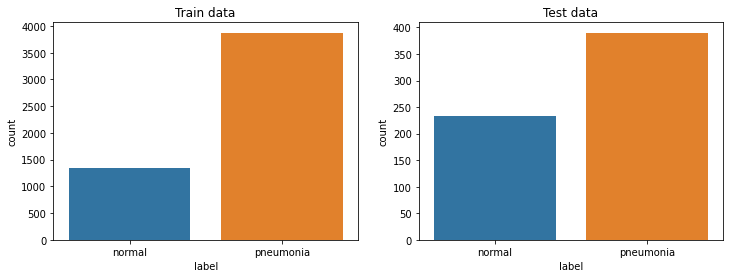

In [9]:

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.countplot(x = cxr_df[cxr_df['fold'] == 'train']['label'])
plt.title('Train data')

plt.subplot(1,2,2)
sns.countplot(x = cxr_df[cxr_df['fold'] == 'test']['label'])
plt.title('Test data')

plt.savefig('class_distribution_sns.png')

plt.show()

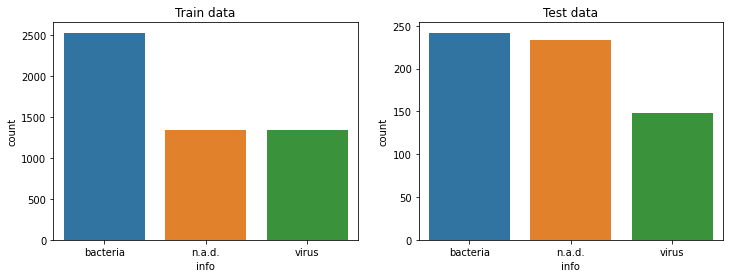

In [10]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.countplot(x = cxr_df[(cxr_df.fold == 'train')]['info'])
plt.title('Train data')

plt.subplot(1,2,2)
sns.countplot(x = cxr_df[(cxr_df.fold == 'test')]['info'])
plt.title('Test data')

plt.savefig('type_distribution_.png')

plt.show()

In [11]:
def show_batch(batch, size, hspace=0.28, wspace=0.2, title=None):
    """Show the images in the `batch`."""
    height, width = size

    plt.figure(figsize=(10,10))
    
    if title is not None:
        plt.suptitle(title, weight='bold', y=0.96)

    for n in range(height*width):
        ax = plt.subplot(height, width, n+1)
        
        plt.imshow(batch[n][0])
        plt.title(batch[n][1])
        plt.subplots_adjust(wspace=wspace, hspace=hspace)
        plt.axis("off")

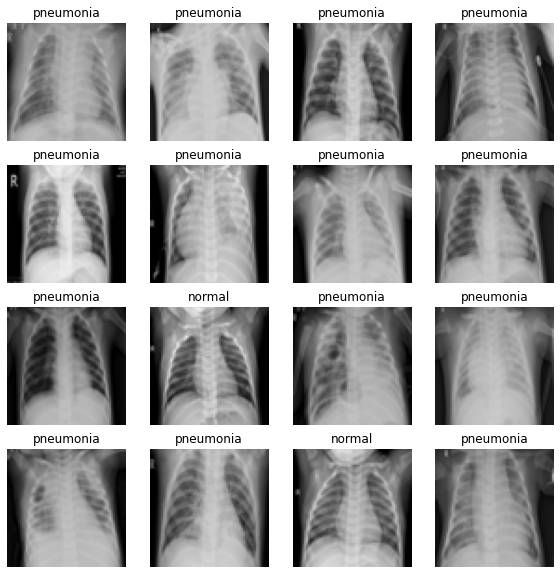

In [12]:

# random batch from the dataset
sample_batch = cxr_df[['image', 'label']].sample(frac=1).to_numpy()

show_batch(sample_batch, size=(4, 4), hspace=0.2, wspace=0.1)
plt.savefig('sample_batch.png')

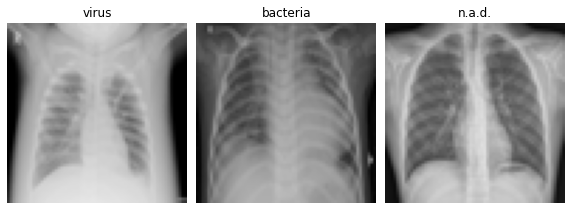

In [13]:
# get differnt types of images from the dataset (virus, bacterial, n.a.d.)
pneumonia_virus_xray = cxr_df[(cxr_df['label']=='pneumonia') & (cxr_df['info']=='virus')].iloc[0][['image', 'info']]
pneumonia_bacteria_xray = cxr_df[(cxr_df['label']=='pneumonia') & (cxr_df['info']=='bacteria')].iloc[0][['image', 'info']]
normal_xray = cxr_df[(cxr_df['label']=='normal')].iloc[0][['image', 'info']]

sample_batch = [pneumonia_virus_xray, pneumonia_bacteria_xray, normal_xray]
show_batch(sample_batch, size=(1,3), wspace=0.05)

plt.savefig('different_types.png')

In [14]:
# input image size
IMAGE_SIZE = (64, 64, 3)

# instantiate a base model with pre-trained weights
vgg19 = VGG19(weights='imagenet',         # load weights pre-trained on ImageNet
              include_top=False,          # do not include the ImageNet classifier at the top
              input_shape=IMAGE_SIZE)  

# freeze the base model
vgg19.trainable = False

# create a new model on top
inputs = keras.Input(shape=IMAGE_SIZE)
x = vgg19(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

80142336/80134624 [==============================] - 1s 0us/step


In [15]:
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
vgg19 (Functional)           (None, 2, 2, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 20,024,897
Trainable params: 513
Non-trainable params: 20,024,384
_________________________________________________________________


In [17]:
train_cxr_df = cxr_df[cxr_df['fold']=='train']
test_cxr_df = cxr_df[cxr_df['fold']=='test']

X_train = np.stack(train_cxr_df['image'].to_numpy())
y_train = train_cxr_df['classID'].to_numpy()

X_test = np.stack(test_cxr_df['image'].to_numpy())
y_test = test_cxr_df['classID'].to_numpy()

In [18]:
pos, neg = train_cxr_df.label.value_counts().to_numpy()

weight_for_0 = (1 / neg)*(pos+neg)/2.0 
weight_for_1 = (1 / pos)*(pos+neg)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.94
Weight for class 1: 0.67


In [19]:
BATCH_SIZE = 32

datagen = ImageDataGenerator(rescale=1.0/255.0)

train_it = datagen.flow(X_train, 
                        y=y_train, 
                        batch_size=BATCH_SIZE, 
                        shuffle=True)

val_it = datagen.flow(X_test, 
                      y=y_test, 
                      batch_size=BATCH_SIZE, 
                      shuffle=False)

In [20]:
EPOCHS = 25

# configure the model for training (Adam, Binary Cross-Entropy, Accuracy)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=[keras.metrics.BinaryAccuracy()])

# train only the trainable layers
history1 = model.fit(train_it, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=val_it, class_weight=class_weight)

Epoch 1/25
163/163 [==============================] - 303s 2s/step - loss: 0.6880 - binary_accuracy: 0.3397 - val_loss: 0.6475 - val_binary_accuracy: 0.6923
Epoch 2/25
163/163 [==============================] - 304s 2s/step - loss: 0.6099 - binary_accuracy: 0.7736 - val_loss: 0.6121 - val_binary_accuracy: 0.7580
Epoch 3/25
163/163 [==============================] - 302s 2s/step - loss: 0.5833 - binary_accuracy: 0.7933 - val_loss: 0.5757 - val_binary_accuracy: 0.7772
Epoch 4/25
163/163 [==============================] - 304s 2s/step - loss: 0.5463 - binary_accuracy: 0.8199 - val_loss: 0.5496 - val_binary_accuracy: 0.7933
Epoch 5/25
163/163 [==============================] - 302s 2s/step - loss: 0.5116 - binary_accuracy: 0.8313 - val_loss: 0.5304 - val_binary_accuracy: 0.8029
Epoch 6/25
163/163 [==============================] - 305s 2s/step - loss: 0.4800 - binary_accuracy: 0.8473 - val_loss: 0.5119 - val_binary_accuracy: 0.8061
Epoch 7/25
163/163 [==============================] - 303s

In [21]:
EPOCHS_FT = 1

# unfreeze the base model
vgg19.trainable = True

# recompile the model after changing the value of learning rate
model.compile(optimizer=keras.optimizers.Adam(1e-5),  
              loss=keras.losses.BinaryCrossentropy(),
              metrics=[keras.metrics.BinaryAccuracy()])

# train end-to-end
history2 = model.fit(train_it, epochs=EPOCHS_FT, batch_size=BATCH_SIZE, validation_data=val_it, class_weight=class_weight)

163/163 [==============================] - 1164s 7s/step - loss: 0.1701 - binary_accuracy: 0.9272 - val_loss: 0.3272 - val_binary_accuracy: 0.8782


In [22]:
def show_history(history, figsize=(15,5), save_fig=True, print_results=True):
    """Show accuracy and loss graphs for the train and test sets."""      
    
    df = pd.DataFrame(history)

    sns.set()
    plt.figure(figsize=figsize)

    # accuracy graph
    plt.subplot(1,2,1)
    g = sns.lineplot(data=df[['binary_accuracy', 'val_binary_accuracy']], dashes=False)
    g.set(title='Model Accuracy', xlabel='Epoch', ylabel='Accuracy')
    g.legend(labels=['train', 'validation'])

    # loss graph
    plt.subplot(1,2,2)
    g = sns.lineplot(data=df[['loss', 'val_loss']], dashes=False)
    g.set(title='Model loss', xlabel='Epoch', ylabel='Loss')
    g.legend(labels=['train', 'validation'])

    plt.subplots_adjust(wspace=0.23)
    
    if save_fig:
        plt.savefig('acc_loss_graphs.png')

    plt.show()

    if print_results:
        print('\n\tMax train accuracy: %.4f %%\033[0m\t\t\t\tMin train loss: %.5f' % (df.binary_accuracy.max() * 100,
                                                                                      df.loss.min()))
        print('\tMax validation accuracy: %.4f %%\t\t\tMin validation loss: %.5f' % (df.val_binary_accuracy.max() * 100, 
                                                                                     df.val_loss.min()))

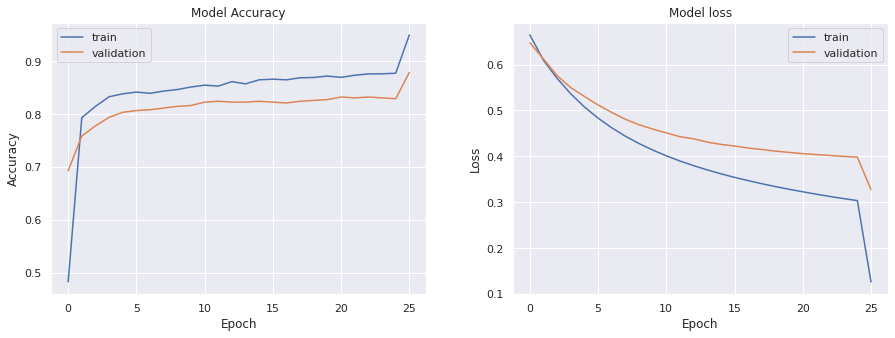


	Max train accuracy: 94.9195 %				Min train loss: 0.12576
	Max validation accuracy: 87.8205 %			Min validation loss: 0.32718


In [23]:
# append the fine-tuning history to the total history
history1.history['binary_accuracy'] += history2.history['binary_accuracy']
history1.history['val_binary_accuracy'] += history2.history['val_binary_accuracy']
history1.history['loss'] += history2.history['loss']
history1.history['val_loss'] += history2.history['val_loss']

show_history(history1.history)

In [24]:
labels =  ['normal', 'pneumonia']

y_true = y_test
y_pred = tf.round(model.predict(x=val_it, batch_size=BATCH_SIZE)).numpy().T[0]

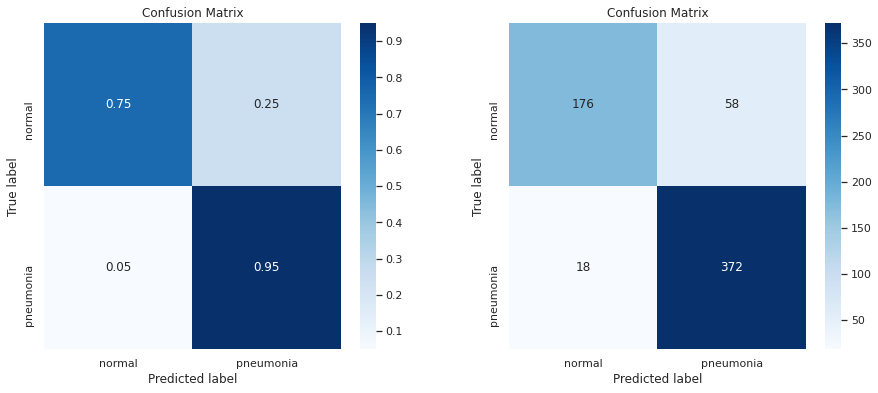

In [25]:
# compute confusion matrices
cm = confusion_matrix(y_true=y_test, y_pred=y_pred) 
cm_normalized = confusion_matrix(y_true=y_test, y_pred=y_pred, normalize='true') 

# plot matrices and save the fig.
plt.figure(figsize=(15,6))

for i, cmx in enumerate([cm_normalized, cm]):
    plt.subplot(1,2,i+1)
    cmx_df = pd.DataFrame(cmx, columns=labels, index=labels).round(2)
    g = sns.heatmap(cmx_df, annot=True, fmt='g', cmap='Blues')
    g.set(title='Confusion Matrix', xlabel='Predicted label', ylabel='True label')

plt.subplots_adjust(wspace=0.25)
plt.savefig('confusion_matrices.png')
plt.show()

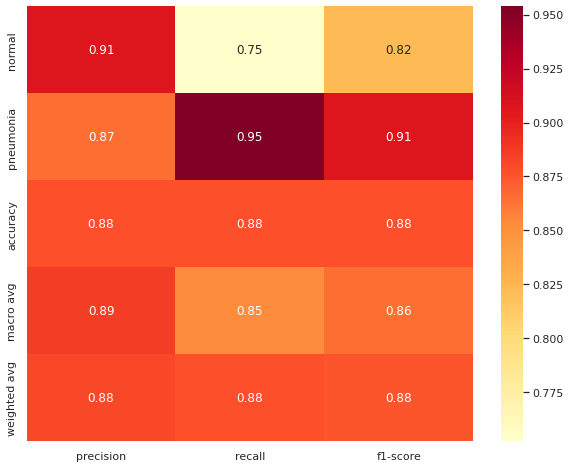

In [26]:
# compute precision, recall and f1-score
report = classification_report(y_true, y_pred, target_names=['normal', 'pneumonia'], output_dict=True)
report = pd.DataFrame(report).iloc[:-1, :].T

# plot the classificaton report
plt.figure(figsize=(10,8))
sns.heatmap(report, annot=True, cmap='YlOrRd')
plt.yticks(va='center')
plt.savefig('classifcation_report.png')
plt.show()

In [27]:
def plot_top_losses(k, X, y_true, predict, loss, labels, **kwargs):
    y_pred = predict(x=X, batch_size=BATCH_SIZE)
    loss_values = np.array(loss(y_true, y_pred))
    top_k = loss_values.argsort()[-k:][::-1]

    worst_batch = []
    for idx in top_k:
        true_prob = y_test[idx]*y_pred[idx] + (1-y_test[idx])*(1-y_pred[idx])
        classID = int(y_true[idx])
        title = '%s / %.3f / %.4f' % (labels[classID], loss_values[idx], true_prob)
        worst_batch.append((X[idx], title))

    show_batch(worst_batch, title='Actual/Loss/Prediction_Probability', **kwargs)

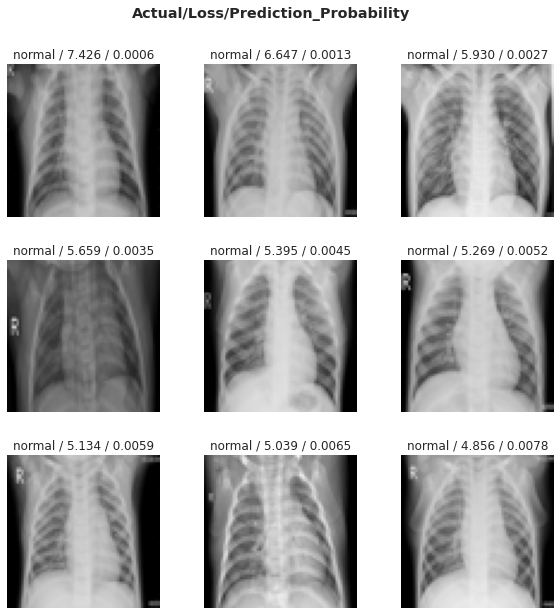

In [28]:
loss_f = keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)

plot_top_losses(k=9,
                X=X_test/255.0, 
                y_true=y_test.reshape(-1, 1),               
                predict=model.predict, 
                loss=loss_f, 
                labels=labels,
                size=(3,3))

plt.savefig('top_losses.png', dpi=350)

In [30]:
print("Successfully Completed the Project")

Successfully Completed the Project
